# Juntar datos

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

nlp = spacy.load('es_core_news_md')
sns.set(style='whitegrid')

In [2]:
tgdata = pd.read_csv('tg_bot.csv')
tgdata.head(2)

,sentence,vote
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra
1,Internacional de Porto Alegre habría llegado a...,Neutra


In [3]:
tgdata.rename(columns = {'vote':'sentiment'}, inplace = True)
tgdata.columns

Index(['sentence', 'sentiment'], dtype='object')

In [4]:
airlinesdata = pd.read_csv('tweets_public.csv')
airlinesdata.head(2)

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,neutral,False,0,0,Trabajar en #Ryanair como #TMA: https://t.co/r...,NaN,Fri Nov 03 12:05:12 +0000 2017,926419989107798016,NaN,Madrid
1,neutral,True,0,0,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,NaN,Sun Nov 26 18:40:28 +0000 2017,934854385577943041,NaN,Mexico City


In [5]:
airlinesdata = airlinesdata[['airline_sentiment','text']]
airlinesdata.rename(columns = {'airline_sentiment':'sentiment', 'text':'sentence'}, inplace = True)
airlinesdata.head(2)

,sentiment,sentence
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...


In [6]:
translateDict = {
    'positive':'Positiva',
    'neutral':'Neutra',
    'negative':'Negativa'
}

In [7]:
airlinesdata['sentiment'] = airlinesdata['sentiment'].map(translateDict)

In [8]:
frames = [tgdata, airlinesdata]
data = pd.concat(frames)
data.reset_index(drop=True, inplace=True)
data.head()

,sentence,sentiment
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra
1,Internacional de Porto Alegre habría llegado a...,Neutra
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva
3,Estoy triste quiero tatuarme,Negativa
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa


<AxesSubplot:xlabel='sentiment', ylabel='sentence'>

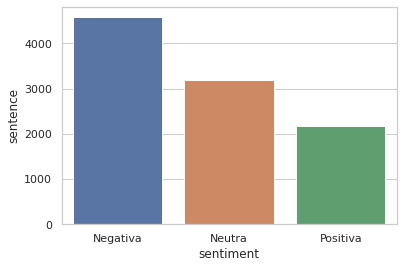

In [9]:
aux = data.groupby('sentiment').count()
sns.barplot(data = aux, x = aux.index, y = 'sentence')

In [10]:
data['sentiment'].value_counts()

Negativa    4575
Neutra      3177
Positiva    2180
Name: sentiment, dtype: int64

# Preprocesar datos

In [11]:
data['tokens'] = data['sentence'].str.lower()
data.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitamos #acogida responsable para wolf. po...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional de porto alegre habría llegado a...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...
3,Estoy triste quiero tatuarme,Negativa,estoy triste quiero tatuarme
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,ㅤ\n\n soñé que al fin\n volv...


In [6]:
def only_words(sentence):
    url_reg = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_reg = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_reg = re.compile('[ ]{2,}')
    
    result = url_reg.sub('', sentence)
    result = html_reg.sub('', result)
    result = spaces_reg.sub('', result)
    result = re.findall('\w+', result)
    result = [''.join(x for x in i if x.isalpha()) for i in result]
    result = ' '.join(result)
    
    return result

In [13]:
data['tokens'] = data['tokens'].apply(only_words)
data.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitamos acogida responsable para wolf por ...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional de porto alegre habría llegado a...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,que alegre está dmtzdmr
3,Estoy triste quiero tatuarme,Negativa,estoy triste quiero tatuarme
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,ㅤ soñé que al fin volvíamos a abrazarnos nunca...


In [7]:
def remove_stop_words(sentence):
    result = ""
    if sentence != None:
        sentence = sentence.split(" ")
        result = list(filter(lambda l: (l not in STOP_WORDS and len(l) > 2), sentence))
        result = ' '.join(result)
    return result

In [15]:
data['tokens'] = data['tokens'].apply(remove_stop_words)
data.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitamos acogida responsable wolf asuntos l...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre habría llegado fich...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr
3,Estoy triste quiero tatuarme,Negativa,triste quiero tatuarme
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñé volvíamos abrazarnos despertar pareció tr...


In [8]:
def lematize(sentence):
    doc = nlp(sentence)
    result = ""
    for token in doc:
        result += token.lemma_ + " "
    return result

In [17]:
data['tokens'] = data['tokens'].apply(lematize)
data.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitar acogido responsable wolf asunto lega...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre haber llegar fichar...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr
3,Estoy triste quiero tatuarme,Negativa,triste querer tatuar yo
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñar volver abrazar yo despertar parecer triste


In [9]:
def remove_accents(sentence):
    replacements = {
        "á" : "a",
        "é" : "e",
        "í" : "i",
        "ó" : "o",
        "ú" : "u",
    }
    for i,j in replacements.items():
        sentence = sentence.replace (i,j)
    return sentence

In [19]:
data['tokens'] = data['tokens'].apply(remove_accents)
data.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitar acogido responsable wolf asunto lega...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre haber llegar fichar...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr
3,Estoy triste quiero tatuarme,Negativa,triste querer tatuar yo
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñar volver abrazar yo despertar parecer triste


In [20]:
data = data[data['tokens'].map(lambda d: d != "")]
data = data.reset_index()
data = data.drop(columns={'index'})
data.head()

,sentence,sentiment,tokens
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitar acogido responsable wolf asunto lega...
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre haber llegar fichar...
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr
3,Estoy triste quiero tatuarme,Negativa,triste querer tatuar yo
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñar volver abrazar yo despertar parecer triste


<AxesSubplot:xlabel='sentiment', ylabel='sentence'>

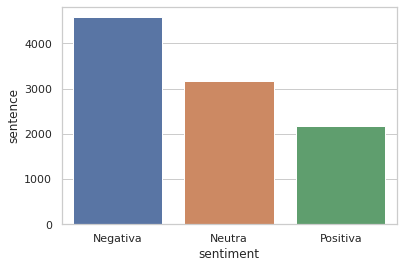

In [21]:
aux = data.groupby('sentiment').count()
sns.barplot(data = aux, x = aux.index, y = 'sentence')

In [22]:
data['sentiment'].value_counts()

Negativa    4575
Neutra      3174
Positiva    2176
Name: sentiment, dtype: int64

In [23]:
codes = {
    'Positiva': 1,
    'Neutra': 0,
    'Negativa' : -1
}
data['sentiment_code'] = data['sentiment']
data = data.replace({'sentiment_code' : codes})
data.head()

,sentence,sentiment,tokens,sentiment_code
0,NECESITAMOS #ACOGIDA RESPONSABLE PARA WOLF. PO...,Neutra,necesitar acogido responsable wolf asunto lega...,0
1,Internacional de Porto Alegre habría llegado a...,Neutra,internacional porto alegre haber llegar fichar...,0
2,Que alegre está!!💕💕😘😘🦋🦋\n@dmtzdmr https://t.co...,Positiva,alegre dmtzdmr,1
3,Estoy triste quiero tatuarme,Negativa,triste querer tatuar yo,-1
4,ㅤ\n\n Soñé que al fin\n volv...,Negativa,soñar volver abrazar yo despertar parecer triste,-1


In [24]:
data.to_pickle("sentiment_data.pickle")

In [65]:
def tokenize(dataframe):
    """
    La función tendrá como entrada un dataframe con una columna "text" que contendrá el texto crudo inicial.
    Devolverá un dataframe similar pero con la columna "tokens" añadida.
    """
    data = dataframe.copy()
    
    data['tokens'] = data['sentence'].str.lower()
    data['tokens'] = data['tokens'].apply(only_words)
    data['tokens'] = data['tokens'].apply(remove_stop_words)
    data['tokens'] = data['tokens'].apply(lematize)
    data['tokens'] = data['tokens'].apply(remove_accents)
    
    return data

# Creación y entrenamiento del modelo

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'],
                                                    data['sentiment_code'],
                                                    test_size=0.10)

In [27]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        max_features=10000,
                        norm='l2',
                        sublinear_tf=True)

In [28]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

In [29]:
with open('tfidf.pickle', 'wb') as file_tfidf:
    pickle.dump(tfidf, file_tfidf)

In [30]:
rfc = RandomForestClassifier()
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
params = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100],
}

In [32]:
gridsearch = GridSearchCV(estimator = rfc,
                          param_grid = params,
                          cv = 2,
                          n_jobs = 1)

gridsearch.fit(features_train, labels_train)
print(gridsearch.best_params_)
print(gridsearch.cv_results_['mean_test_score'])

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
[0.55138827 0.55273175 0.55541872 0.55060457 0.55329154 0.55407524]


In [33]:
rfc = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_features = 'log2', n_estimators = 100)
rfc.fit(features_train, labels_train)

RandomForestClassifier(max_features='log2')

In [34]:
with open('rfc.pickle', 'wb') as file_rfc:
    pickle.dump(rfc, file_rfc)